# Plot overpotentials
In this notebook we plot the overpotentials for various models and C-rates.

If this notebook is running on Google Colab, we first need to install PyBaMM (you can skip if not using Google Colab).

In [1]:
%pip install pybamm seaborn -q

You should consider upgrading via the '/home/ferranbrosa/continuum-model-review/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


We start by importing the relevant packages and defining the plotting style

In [2]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_lowercase as abc

cmap=sns.color_palette("colorblind", as_cmap=True)
plt.style.use('seaborn-dark')

Then we can define the models to compare and run the various experiments we want to test (see ["Compare models"](./compare_models.ipynb) for more details on the simulations)

In [3]:
models = [
    pybamm.lithium_ion.SPM(),
    pybamm.lithium_ion.SPMe(),
    pybamm.lithium_ion.DFN()
]
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)
c_rates = ['1C', '2C']
experiment1 = pybamm.Experiment(
    [
        "Discharge at " + c_rates[0] + " until 3.0 V",
    ],
    period="1 minute",
)
experiment2 = pybamm.Experiment(
    [
        "Discharge at " + c_rates[1] + " until 3.0 V",
    ],
    period="1 second",
)
solver = pybamm.CasadiSolver(mode="safe", dt_max=1)
sims = [[], []]
for lr, experiment in enumerate([experiment1, experiment2]):
    for model in models:
        sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment,
                                solver=solver)
        sim.solve(np.linspace(0, 1000, 101))
        sims[lr].append(sim)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


2022-06-10 17:46:08,907 - [WARNING] simulation.solve(809): Ignoring t_eval as solution times are specified by the experiment
2022-06-10 17:46:09,909 - [WARNING] simulation.solve(809): Ignoring t_eval as solution times are specified by the experiment
2022-06-10 17:46:10,984 - [WARNING] simulation.solve(809): Ignoring t_eval as solution times are specified by the experiment
2022-06-10 17:46:13,188 - [WARNING] simulation.solve(809): Ignoring t_eval as solution times are specified by the experiment
2022-06-10 17:46:17,722 - [WARNING] simulation.solve(809): Ignoring t_eval as solution times are specified by the experiment
2022-06-10 17:46:23,324 - [WARNING] simulation.solve(809): Ignoring t_eval as solution times are specified by the experiment


We can finally plot the various overpotentials. These ara analogous to the plots in Figure 9 but without the open-circuit potential contribution so it makes the comparison across models easier.

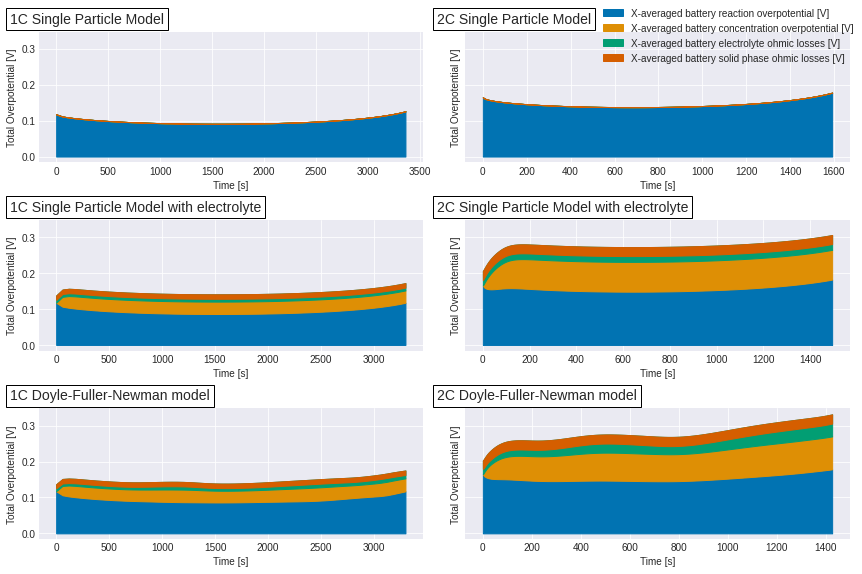

In [4]:
etas = [
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
]
nrow = 3
ncol = 2
fig, all_axes = plt.subplots(nrow, ncol, sharex=False, sharey=True, figsize=(12, 8))
all_axes = all_axes.T
try:
    cols = cmap(np.linspace(0.1, 0.9, 4))
except:
    cols = cmap
abc_counter = 0
for lr in range(2):
    col_sims = sims[lr]
    for ax, sim in enumerate(col_sims):
        axes = all_axes[lr]
        sol = sim.solution
        time = sol['Time [s]'].entries
        base = np.zeros_like(time)
        eta_r = -sol["X-averaged battery reaction overpotential [V]"].entries
        eta_c = -sol["X-averaged battery concentration overpotential [V]"].entries
        eta_e = -sol["X-averaged battery electrolyte ohmic losses [V]"].entries
        eta_s = sol["X-averaged battery solid phase ohmic losses [V]"].entries
        for si, source in enumerate([eta_r, eta_c, eta_e, eta_s]):
            axes[ax].fill_between(time, base, base+source, color=cols[si], label=etas[si])
            base += source
        axes[ax].set_xlabel('Time [s]')
        axes[ax].set_ylabel('Total Overpotential [V]')
        axes[ax].grid()
        t = axes[ax].text(-0.075, 1.15,
                          c_rates[lr] + ' ' +
                          sim.model.name, transform=axes[ax].transAxes,
                    fontsize=14, va='top')
        t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='black'))
        abc_counter += 1

handles, labels = axes[ax].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', )
plt.tight_layout()

The articles that contributed to this notebook are

In [5]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[3] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with